In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import numpy as np
import boto3
import cv2
import math

In [2]:
fs = s3fs.S3FileSystem()

from urllib.parse import urlparse
import json

bucket = 'sxm-ecomm-sagemaker-dev'

s3_client = boto3.client("s3")


def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
#     print(response)
    objects = [content["Key"] for content in response["Contents"]]
    return objects

In [3]:
# Group images by coordinates
import itertools
roadsPath = "image-classification-model-2021-08-04-18-04-52/output/road"
roadFiles = list_objects(s3_client, bucket, roadsPath)

groupedFiles = []
# iterator
# lambda function will return first part from the string
iterator = itertools.groupby(roadFiles, lambda roadFile: roadFile.split('_freq')[0])
# iterating over the result
# element and its group
for element, group in iterator:
   # appending the group by converting it into a list
   groupedFiles.append(list(group))
# printing the result
# print(groupedFiles)

[['image-classification-model-2021-08-04-18-04-52/output/road/img_31.782211_-97.576846_freq_1.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_32.012106_-90.357557_freq_3.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_34.556566_-117.288937_freq_2.png.out', 'image-classification-model-2021-08-04-18-04-52/output/road/img_34.556566_-117.288937_freq_3.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_35.270870_-111.544006_freq_2.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_36.168284_-95.922185_freq_1.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_36.493792_-90.064697_freq_3.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_36.642210_-93.204353_freq_2.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/img_37.056880_-120.855790_freq_2.png.out'], ['image-classification-model-2021-08-04-18-04-52/output/road/

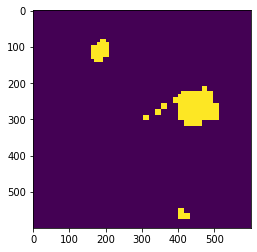

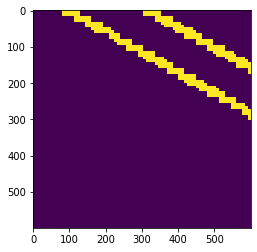

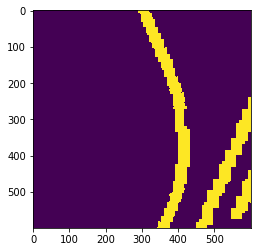

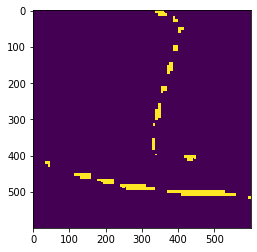

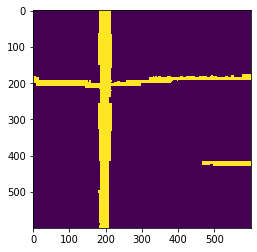

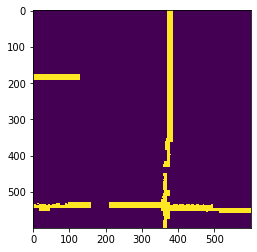

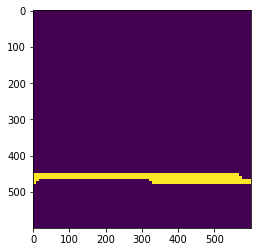

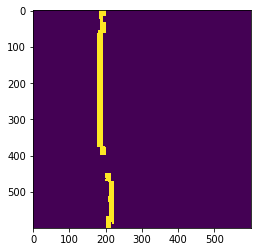

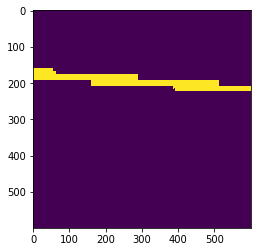

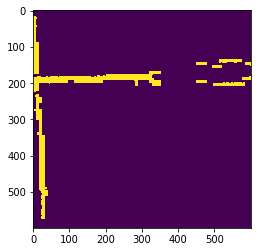

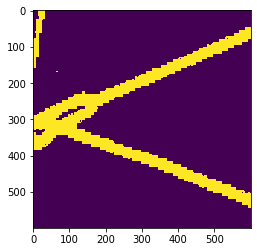

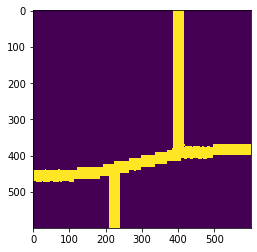

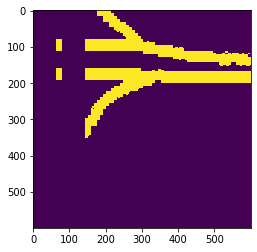

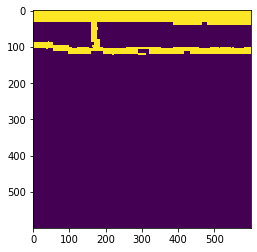

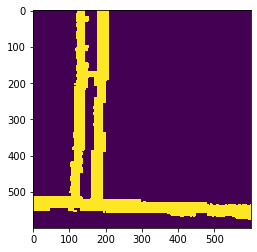

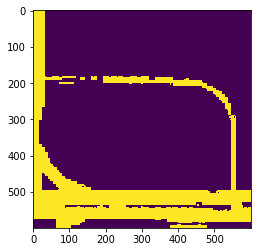

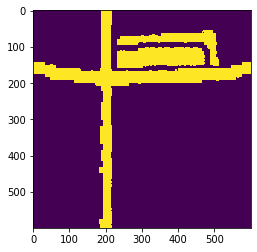

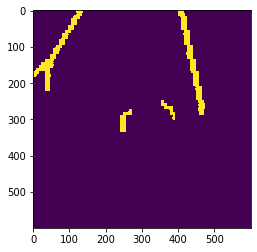

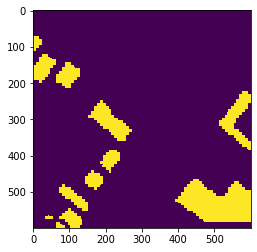

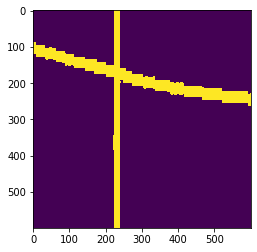

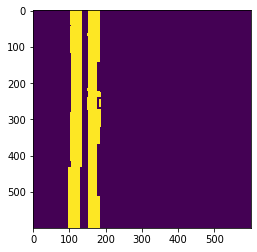

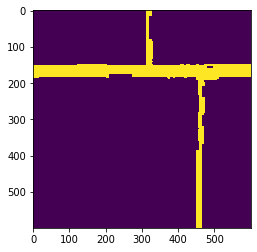

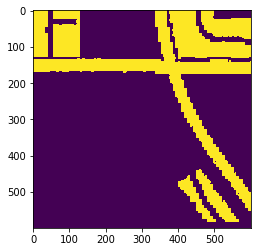

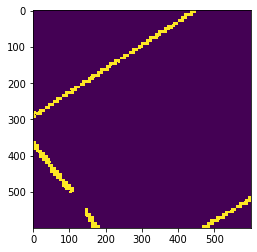

In [4]:
# Stack images 
# output: image-classification-model-2021-07-20-16-01-54/output/other/img_21.331533, -157.865814_freq_2.png.out
result = {}

print(groupedFiles)
for group in groupedFiles:
    initImage = None
    stacked = np.full((600, 600), False)
    coord = group[0].split('_freq')[0].split('img_')[1]
    for imagePath in group:
        imagePath = imagePath.replace('other/', '')
        imagePath = imagePath.replace('road/', '')
        imagePath = imagePath.replace('.out', '')
        imagePath = imagePath.replace('image-classification-model-2021-08-04-18-04-52/output/', 'freqs/')
        with fs.open(bucket + "/" + imagePath) as file:
            image = plt.imread(file, 0)

#             Patch fix for incorrectly saved images
            flatImage = np.reshape(image, (image.shape[0]*image.shape[1], image.shape[2]))
            uniqueColor, counts = np.unique(flatImage, axis=0, return_counts=True)
            imageBW = np.where(image == [253, 231, 36, 255], [1, 1, 1, 1], [0, 0, 0, 0])
            BW = np.prod(imageBW, axis=2)


            stacked = np.logical_or(stacked, BW == 1)
    result[coord] = stacked
    
        
for coord in result:
    plt.imshow(result[coord].astype(int))
    plt.show()
# 

In [6]:
# Create Filterset
# filterSet = []

# a = np.zeros((600, 600))
# np.fill_diagonal(a, 1)
# Create GEOFENCE

numSegment = 4
def genFilters(numSegment, image):
#     border = np.zeros((image.shape[0] - 8, image.shape[1] - 8))
#     border = np.pad(border, 4, 'constant', constant_values=1)
    #plt.imshow(border)
    #plt.show()
    points = []
    for x in range(numSegment + 1):
        points.append((x/numSegment, 0.))

    for y in range(1, numSegment):
        points.append((1., y/numSegment))

    for x in range(numSegment, 0, -1):
        points.append((x/numSegment, 1.))

    for y in range(numSegment, 0, -1):
        points.append((0., y/numSegment))

    filterSet = []
    center = (int(np.round(image.shape[0]/2)), int(np.round(image.shape[1]/2)))
    for point in points:
        newFilter = np.zeros(image.shape)
        scaled = (int(np.round(point[0] * image.shape[0])), int(np.round(point[1] * image.shape[1])))
    #     print(center)
    #     print(scaled)
        cv2.line(newFilter, center, scaled, 1, 3)
#         newFilter = np.logical_or(newFilter, border)
        #plt.imshow(newFilter)
        #plt.show()
        filterSet.append(newFilter)
    #     drawline
    # select candidate points
    # for each cand find distance
    # select least dist cand
    # add to vertices
    return filterSet

def getVertices(filterSet, image):
    center = (int(np.round(image.shape[0]/2)), int(np.round(image.shape[1]/2)))
    vertices = []
    # plt.imshow(stacked)
    # plt.show()
    for filt in filterSet:
    #     filtered = np.divide(stacked, (2*filt), out=np.zeros_like(stacked), where=filt!=0)
    #     plt.imshow(filt)
    #     plt.show()
        filtered = np.logical_and(filt, image)
    #     plt.imshow(filtered)
    #     plt.show()
        indices = np.argwhere(filtered)
    #     print(indices)
    #     print(indices - center)
        minIndex = None
        if len(indices) == 0:
            indices = np.argwhere(filt)
            distances = np.linalg.norm(indices-center, axis = 1)
            maxIndex = np.argmax(distances)
            minIndex = maxIndex
        else:
            indices = np.argwhere(filtered)
            distances = np.linalg.norm(indices - center, axis=1)
            minIndex = np.argmin(distances)
            
        vertices.append(indices[minIndex])
    return vertices
#print(vertices)
#print(distances)
# indices = np.argwhere(filtered == .5)
# minDist = 10000
# bestIndex = None
# for index in indices:
#     dist = np.norm(index - [300, 300])
#     if dist < minDist:
#         minDist = dist
#         bestIndex = index
#     vertices.append(bestIndex)

In [28]:
def plotVertices(vertices, image):
    x = []
    y = []
    for vertex in vertices:
        x.append(vertex[1])
        y.append(vertex[0])
    #     plt.plot(vertex[1], vertex[0], marker='v', color="red")
    #     plt.imshow(stacked)
    #     plt.show()
    x.append(x[0])
    y.append(y[0])
#    for n, i in enumerate(x):
#        if (i == 0):
#            x[n] = 100
#        if (i == 599):
#            x[n] = 530
#    for n, i in enumerate(y):
#        if (i == 0):
#            y[n] = 100
#        if (i == 599):
#            y[n] = 530
#    print(x)
#    print(y)
    #print(vertices)
    plt.plot(x, y, color='r')
    plt.imshow(image)
    plt.show()

def getPointLatLng(x, y, w, h, zoom, lat, lng):
    parallelMultiplier = math.cos(lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = lat - degreesPerPixelY * ( y - h / 2)
    pointLng = lng + degreesPerPixelX * ( x  - w / 2)

    return (pointLat, pointLng)

In [29]:
w = 600
h = 600
zoom = 19
output = {}
for coord in result:
    #print (coord)
    split = coord.split('_')
    lat = float(split[0])
    lng = float(split[1])
    image = result[coord]
    filterSet = genFilters(4, image)
    vertices = getVertices(filterSet, image)
    #print(vertices)
    verticesLatLng = []
    for vertex in vertices:
        verticesLatLng.append(getPointLatLng(vertex[0], vertex[1], w, h, zoom, lat, lng))
    output[coord] = verticesLatLng
    #print(verticesLatLng)
        
#     print(vertices)
    #plotVertices(vertices, image)
#     plt.imshow(result[coord].astype(int))
#     plt.show()

In [30]:
output

{'31.782211_-97.576846': [(31.7828950085687, -97.57765066270447),
  (31.782423042656298, -97.5773314798317),
  (31.782215560057125, -97.57765066270447),
  (31.78220187988575, -97.57685404662705),
  (31.78220187988575, -97.57684868220902),
  (31.78220187988575, -97.576846),
  (31.78220187988575, -97.576846),
  (31.78220187988575, -97.576846),
  (31.78220187988575, -97.57684063558197),
  (31.78220187988575, -97.57683795337296),
  (31.782215560057125, -97.57604401950455),
  (31.782557564341474, -97.57604401950455),
  (31.7828950085687, -97.57604401950455),
  (31.7828950085687, -97.57643830422974),
  (31.7828950085687, -97.57685136441803),
  (31.7828950085687, -97.57725369577027)],
 '32.012106_-90.357557': [(32.012788302564154, -90.35836166270447),
  (32.01236982365814, -90.35819268353653),
  (32.012106, -90.35802102215958),
  (32.01195134475213, -90.35790836938095),
  (32.01186491976067, -90.35784936078262),
  (32.011751202666645, -90.35776353009415),
  (32.0114418921709, -90.357557),
  (